In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [87]:
def rmse(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

def likelihood(estimator, X, y):
    sigma2 = get_sigma2(estimator)
    y_pred = estimator.predict(X)
    n = y.size
    return -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum((y - y_pred) ** 2) / sigma2

def logloss(estimator, X, y):
    return -likelihood(estimator, X, y)

def get_sigma2(estimator):
    e = estimator
    if isinstance(e, (RidgeULNML, RidgeRandomSearch)):
        return e.sigma2_
    if isinstance(e, (RidgeCV, LassoCV)):
        return e.sigma2_
    if isinstance(e, ARDRegression):
        return 1 / e.alpha_
    raise ValueError("Unsupported type: {}".format(type(estimator)))

In [88]:
# Taken from and modified from sklearn example:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

import numpy as np
import joblib as jl
import warnings
from sklearn import datasets
from sklearn.linear_model import ARDRegression
from src.ulnml.least_square_regression import RidgeULNML
from src.gridsearch.least_square_regression import RidgeRandomSearch, RidgeCVProb as RidgeCV, LassoCVProb as LassoCV
from sklearn.model_selection import learning_curve as _learning_curve
from sklearn.model_selection import ShuffleSplit


memory = jl.Memory(cachedir="tmp", verbose=False)
learning_curve = memory.cache(_learning_curve)


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, scoring=rmse,
                        n_jobs=1, train_sizes=10. ** np.linspace(-1, 0, 5), color=None, style=".-"):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, test_scores_mean - 1 * test_scores_std,
                     test_scores_mean + 1 * test_scores_std, alpha=0.05, color=color)
    plt.plot(train_sizes, test_scores_mean, style, color=color,
             label=title)
    return plt

In [89]:
def plot_regression(X, y, ylabel, scoring):
    alphas = 10.0 ** np.arange(-4, 0, 20)
    cv = 5
    ylim = None
    n_jobs = -1
    train_sizes = 5. ** np.linspace(-1, 0, 10)

    plt.grid()
    plt.xlabel("Training samples")
    plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plot_learning_curve(RidgeCV(alphas=alphas, cv=cv), "ridge+CV",
                        X, y, ylim=ylim, scoring=scoring, n_jobs=n_jobs, color="r", style="o:", train_sizes=train_sizes)
    plot_learning_curve(LassoCV(alphas=alphas, cv=cv), "lasso+CV",
                        X, y, ylim=ylim, scoring=scoring, n_jobs=n_jobs, color="b", style="+:", train_sizes=train_sizes)
    plot_learning_curve(RidgeRandomSearch(lam_min=1e-4, lam_max=1, num_grid=20, random_state=420), "RandomSearch",
                        X, y, ylim=ylim, scoring=scoring, n_jobs=n_jobs, color="k", style="x:", train_sizes=train_sizes)
    plot_learning_curve(ARDRegression(fit_intercept=True), "RVM",
                        X, y, ylim=ylim, scoring=scoring, n_jobs=n_jobs, color="g", style="d:", train_sizes=train_sizes)
    plot_learning_curve(RidgeULNML(fit_intercept=False, n_iter=10000), "MDL-RS",
                        X, y, ylim=ylim, scoring=scoring, n_jobs=n_jobs, color="m", style="s-.", train_sizes=train_sizes)
    
    plt.xscale("log")
    plt.legend(loc="best")
    plt.tight_layout()

# Synthetic (Correlated, RMSE)

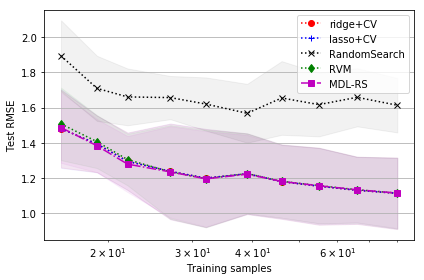

In [80]:
X, y, coef = datasets.make_regression(n_features=5, n_informative=5, random_state=42, noise=1, effective_rank=10, coef=True, bias=1)
plot_regression(X, y, "Test RMSE", rmse)

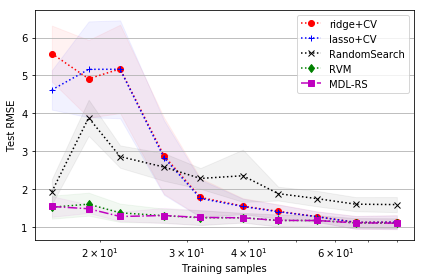

In [81]:
X, y, coef = datasets.make_regression(n_features=20, n_informative=5, random_state=42, noise=1, effective_rank=10, coef=True, bias=1)
plot_regression(X, y, "Test RMSE", rmse)

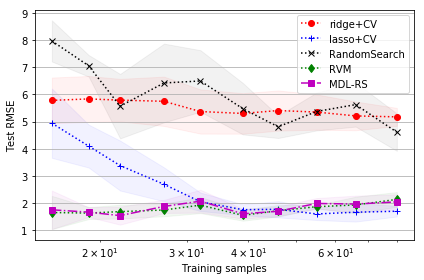

In [82]:
X, y, coef = datasets.make_regression(n_features=100, n_informative=5, random_state=42, noise=1, effective_rank=10, coef=True, bias=1)
plot_regression(X, y, "Test RMSE", rmse)

# Synthetic (Correlated, Likelihood)

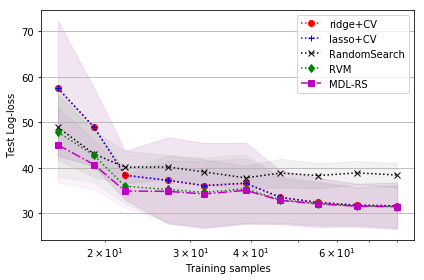

In [83]:
X, y, coef = datasets.make_regression(n_features=5, n_informative=5, random_state=42, noise=1, effective_rank=10, coef=True, bias=1)
plot_regression(X, y, "Test Log-loss", logloss)

(0, 100)

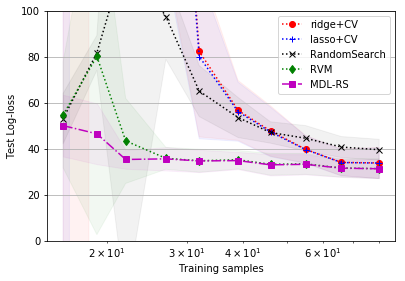

In [84]:
X, y, coef = datasets.make_regression(n_features=20, n_informative=5, random_state=42, noise=1, effective_rank=10, coef=True, bias=1)
plot_regression(X, y, "Test Log-loss", logloss)
plt.ylim(0, 100)

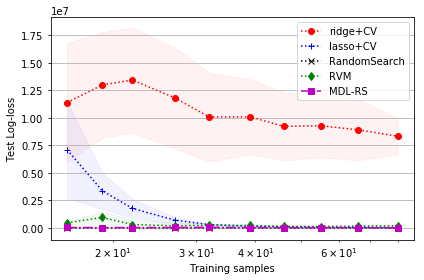

In [90]:
X, y, coef = datasets.make_regression(n_features=100, n_informative=5, random_state=42, noise=1, effective_rank=10, coef=True, bias=1)
plot_regression(X, y, "Test Log-loss", logloss)
# plt.ylim(-10000000, 0)

# Synthetic (Uncorrelated, RMSE)

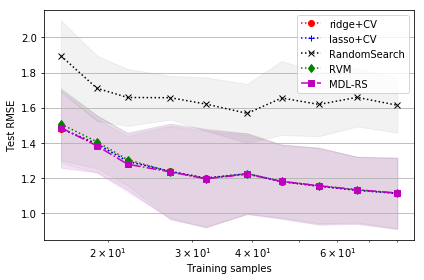

In [91]:
X, y, coef = datasets.make_regression(n_features=5, n_informative=5, random_state=42, noise=1, coef=True, effective_rank=50, bias=1)
plot_regression(X, y, "Test RMSE", rmse)

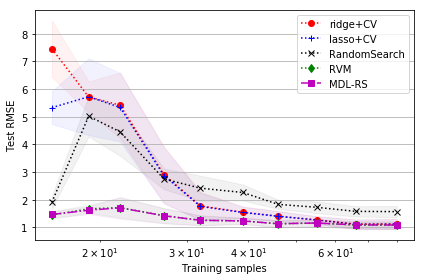

In [92]:
X, y, coef = datasets.make_regression(n_features=20, n_informative=5, random_state=42, noise=1, coef=True, effective_rank=50, bias=1)
plot_regression(X, y, "Test RMSE", rmse)

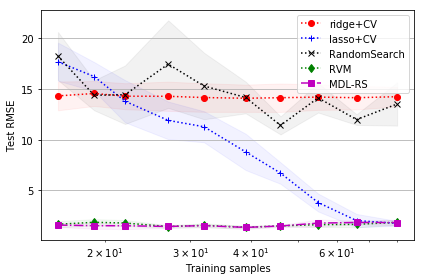

In [93]:
X, y, coef = datasets.make_regression(n_features=100, n_informative=5, random_state=42, noise=1, coef=True, effective_rank=100, bias=1)
plot_regression(X, y, "Test RMSE", rmse)

# Synthetic (Uncorrelated, Likelihood)

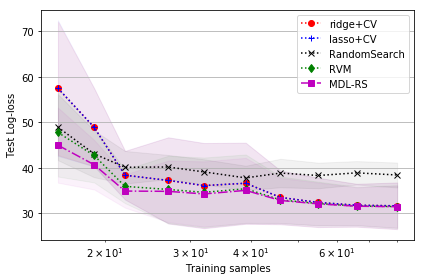

In [94]:
X, y, coef = datasets.make_regression(n_features=5, n_informative=5, random_state=42, noise=1, effective_rank=100, coef=True, bias=1)
plot_regression(X, y, "Test Log-loss", logloss)

(0, 100)

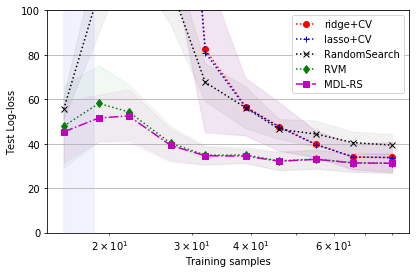

In [95]:
X, y, coef = datasets.make_regression(n_features=20, n_informative=5, random_state=42, noise=1, effective_rank=100, coef=True, bias=1)
plot_regression(X, y, "Test Log-loss", logloss)
plt.ylim(0, 100)

(0, 100000.0)

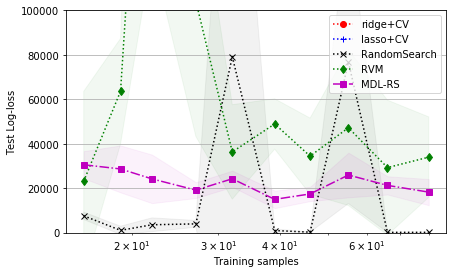

In [97]:
X, y, coef = datasets.make_regression(n_features=100, n_informative=5, random_state=42, noise=1, effective_rank=100, coef=True, bias=1)
plot_regression(X, y, "Test Log-loss", logloss)
plt.ylim(0, 1e5)